In [1]:
pip install medmnist

     -------------------------------------- 162.6/162.6 MB 1.9 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 88.3/88.3 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 12.1/12.1 MB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 4.2/4.2 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 1.6 MB/s eta 0:00:00
     -------------------------------------- 178.9/178.9 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 1.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116947 sha256=8b810587b643f9a83ceab8a9844aad798624

In [16]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
data_flag = 'bloodmnist'
download = True

BATCH_SIZE = 128


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Read the MedMNIST data, preprocess and encapsulate into dataloader form

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 35461855/35461855 [04:34<00:00, 129223.75it/s]


Using downloaded and verified file: C:\Users\Kirthana\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\Kirthana\.medmnist\bloodmnist.npz


In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\Kirthana\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC 

In [7]:
# visualization

train_dataset.montage(length=1)

c:\Users\Kirthana\AppData\Local\Programs\Python\Python37\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


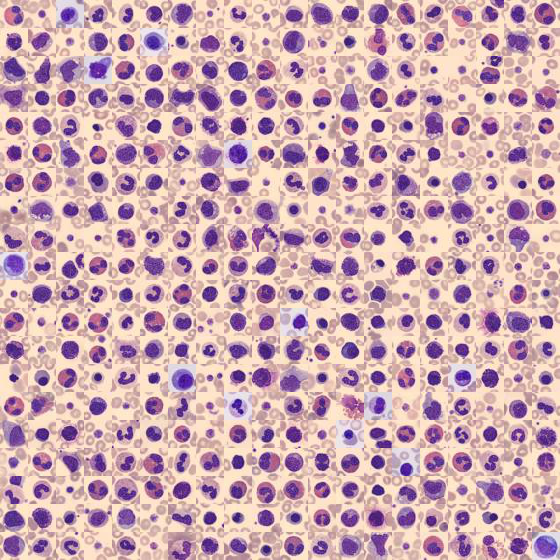

In [8]:
# visualization

train_dataset.montage(length=20)

In [9]:
train_dataset

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\Kirthana\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC 

In [10]:
train_dataset.info

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'task': 'multi-class',
 'label': {'0': 'basophil',
  '1': 'eosinophil',
  '2': 'erythroblast',
  '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
  '4': 'lymphocyte',
  '5': 'monocyte',
  '6': 'neutrophil',
  '7': 'platelet'},
 'n_channels': 3,
 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421},
 '

In [11]:
train_dataset.imgs.shape

(11959, 28, 28, 3)

In [12]:
train_dataset.labels.shape

(11959, 1)

In [13]:
list(train_dataset.info.keys())

['python_class',
 'description',
 'url',
 'MD5',
 'task',
 'label',
 'n_channels',
 'n_samples',
 'license']

In [88]:
x_train = np.array([x.flatten() for x in train_dataset.imgs])
y_train=train_dataset.labels

In [89]:
x_train.shape

(11959, 2352)

### Class Imbalance

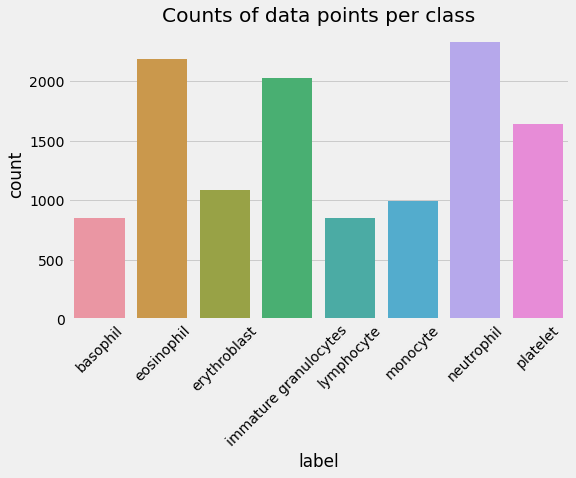

In [119]:
plt.figure(figsize=(8,5))
plt.title('Counts of data points per class')
y_train=pd.DataFrame(y_train)
label_map = train_dataset.info['label']
sns.countplot(x = y_train.iloc[:, 0])
old_xaxis = [int(x) for x in list(label_map.keys())]
new_axis = list(label_map.values())
new_axis[3] = 'immature granulocytes'
plt.xticks(old_xaxis, new_axis, rotation=45)
plt.xlabel('label')
plt.show()

### t-SNE

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

c:\Users\Kirthana\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Kirthana\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11959 samples in 0.048s...
[t-SNE] Computed neighbors for 11959 samples in 24.315s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 385.645257
[t-SNE] KL diverge

In [22]:
x_train=pd.DataFrame(x_train)
y_train=np.array(y_train)

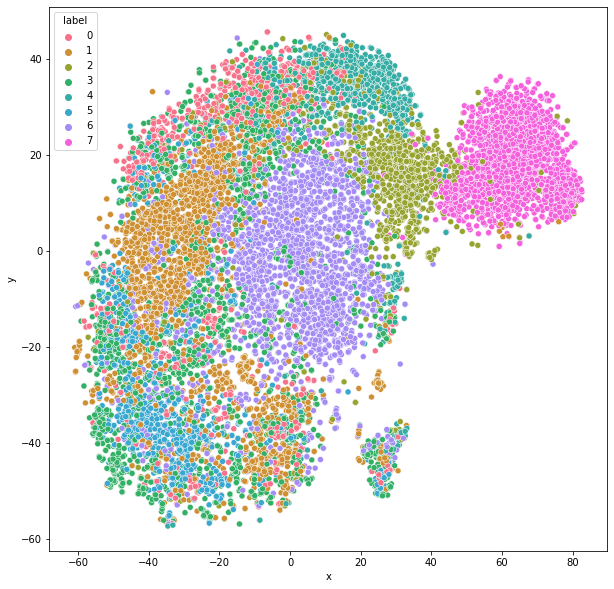

In [23]:
df_tsne= pd.DataFrame(columns = ["x", "y", "label"] )
df_tsne["x"] = tsne[:,0]
df_tsne["y"] = tsne[:,1]
df_tsne["label"] = y_train

plt.figure(figsize = (10,10))
sns.scatterplot(x = df_tsne["x"], y = df_tsne["y"], hue = df_tsne["label"],  palette = sns.color_palette("husl",8))
plt.show()

### PCA

In [24]:
x_train=pd.DataFrame(x_train)
y_train=pd.DataFrame(y_train)

In [25]:
from sklearn.decomposition import PCA

feature_selector = PCA(120, random_state=0)
x_train = feature_selector.fit_transform(x_train)

pca_plot_df = pd.DataFrame(data=x_train[:,0:2], columns=['PC 1', 'PC 2'])
pca_plot_df = pd.concat([pca_plot_df, y_train], axis=1)

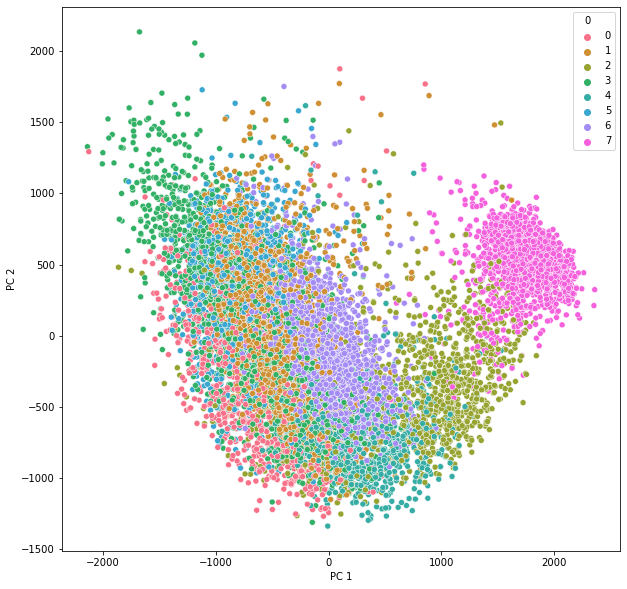

In [26]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = pca_plot_df['PC 1'], y = pca_plot_df['PC 2'], hue = pca_plot_df.iloc[:,2],  palette = sns.color_palette("husl", 8))
plt.show()

### 3D PCA

In [46]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [109]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pca.fit_transform(x_train)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train.iloc[:, 0],
    title='PCA: '+f'Total Explained Variance is {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [110]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26463844 0.09115098 0.04929541]


### 3D t-SNE

In [56]:
import plotly.express as px

tsne_components = manifold.TSNE(n_components=3, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

c:\Users\Kirthana\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\Kirthana\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11959 samples in 0.009s...
[t-SNE] Computed neighbors for 11959 samples in 4.599s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 376.124457
[t-SNE] KL divergen

In [65]:
fig = px.scatter_3d(
    tsne_components, x=0, y=1, z=2, color=y_train.iloc[:, 0],
    title='tSNE',
    labels={'0': 'x', '1': 'y', '2': 'z'}
)
fig.show()

pixel-EDA pairwise-http://varianceexplained.org/r/digit-eda/